```
Copyright 2022 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```


# SE3DS Example Colab

[Paper](https://arxiv.org/abs/2204.02960) | [Video](https://www.youtube.com/watch?v=lhwwlrRfFp0)

This Colab demonstrates how to load and use a pretrained SE3DS model. This is part of the code for the paper "Simple and Effective Synthesis for 3D Scenes". The full codebase is found at https://github.com/google-research/se3ds/.

It is recommended that you run this Colab with a **GPU runtime**. You might get a warning about file space, but it will be resolved after the checkpoint is extracted / un-tarred.

## Download code, model weights, and install dependencies

In [ ]:
%%shell
echo
svn export --force https://github.com/google-research/se3ds/trunk se3ds
echo Installing required dependencies.
pip install -r se3ds/colab_requirements.txt

echo
echo Fetching trained model weights...
mkdir data
rm -f data/ckpt.tar
rm -rf data/ckpt/
wget https://storage.googleapis.com/gresearch/se3ds/mp3d_ckpt.tar -P data/
echo Extracting model weights...
tar -xf data/mp3d_ckpt.tar --directory data/
rm data/mp3d_ckpt.tar
echo Done.


Cloning into 'se3ds'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 53 (delta 10), reused 52 (delta 9), pack-reused 0
Unpacking objects: 100% (53/53), done.
Installing required dependencies.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 164 kB 10.9 MB/s 
     |████████████████████████████████| 4.1 MB 38.0 MB/s 
     |████████████████████████████████| 61 kB 4.4 MB/s 
     |████████████████████████████████| 1.1 MB 18.2 MB/s 
     |████████████████████████████████| 62 kB 578 kB/s 
     |████████████████████████████████| 38.1 MB 2.3 MB/s 
     |████████████████████████████████| 1.1 MB 32.8 MB/s 
     |████████████████████████████████| 138 kB 39.1 MB/s 
     |████████████████████████████████| 224 kB 43.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uni

## Imports and utils

In [ ]:
import time
import tensorflow as tf
import math
import collections
import numpy as np
import os
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from tqdm import tqdm

from se3ds import constants
from se3ds.models import model_config
from se3ds.models import models
from se3ds.utils import utils
from se3ds.utils import pano_utils

devices = tf.config.experimental.list_logical_devices(device_type="GPU")
print([d.name for d in devices])
strategy = tf.distribute.MirroredStrategy(devices)

['/device:GPU:0']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


### Visualization Utils

In [ ]:
def show_animation(all_video_frames, main_titles=None, axis_titles=None, apply_cmap=False, figsize_scale=3, fps=10):
  images = []
  titles = []
  main_title = None
  legends = []
  max_frames = max([len(x) for x in all_video_frames])
  num_videos = len(all_video_frames)
  fig, ax = plt.subplots(1, num_videos, figsize=(figsize_scale * num_videos, figsize_scale))
  for i in range(num_videos):
    if num_videos == 1:
      axis = ax
    else:
      axis = ax[i]
    if num_videos != 1:
      axis = ax[i]
    curr_frame = all_video_frames[i][0]
    if apply_cmap:
      images.append(axis.imshow(cmap[curr_frame]))
    else:
      images.append(axis.imshow(curr_frame))
    if apply_cmap:
      legend_labels = np.unique(curr_frame)
      patches = [mpatches.Patch(color=cmap[x] / 255, label=x) for x in legend_labels if x != 0]
      legends.append(axis.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.))
    if axis_titles is not None:
      titles.append(axis.text(curr_frame.shape[1] // 2, 0, axis_titles[i][0],
                              horizontalalignment='center', verticalalignment='bottom'))
  if main_titles is not None:
    main_title = plt.figtext(0.5, 0.77, main_titles[0], fontdict={'size': 12}, ha='center', va='center')
  plt.tight_layout()
  plt.close()

  # function to update figure
  def updatefig(j):
      # set the data in the axesimage object
      for i in range(num_videos):
        frame_idx = min(j, len(all_video_frames[i])-1)
        if apply_cmap:
          images[i].set_array(cmap[all_video_frames[i][frame_idx]])
        else:
          images[i].set_array(all_video_frames[i][frame_idx])
        if axis_titles is not None:
          titles[i].set_text(axis_titles[i][j])
        if main_title is not None:
          main_title.set_text(main_titles[j])
      # return the artists set
      return images
  # kick off the animation
  ani = animation.FuncAnimation(fig, updatefig, frames=range(max_frames), 
                                interval=1000/fps, blit=True)
  rc('animation', html='jshtml')
  return ani

## Data

In [ ]:
image_size = 512
distance_per_frame = 0.1  # Distance between frames in metres.
update_every_dist = int(0.1 / distance_per_frame)  # Add points every x iteration.
num_context = 1  # How many frames to provide as context.
fps = 10  # How many frames per second to render videos at.

Load an example pano.

In [ ]:
%%bash
wget --no-check-certificate https://storage.googleapis.com/gresearch/pathdreamer/example_pano.tar -P data/
tar -xf data/example_pano.tar --directory data/

--2022-06-27 15:53:19--  https://storage.googleapis.com/gresearch/pathdreamer/example_pano.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 172.253.120.128, 64.233.184.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1638400 (1.6M) [application/x-tar]
Saving to: ‘data/example_pano.tar’

     0K .......... .......... .......... .......... ..........  3% 39.5M 0s
    50K .......... .......... .......... .......... ..........  6% 41.8M 0s
   100K .......... .......... .......... .......... ..........  9% 44.4M 0s
   150K .......... .......... .......... .......... .......... 12% 51.2M 0s
   200K .......... .......... .......... .......... .......... 15% 46.2M 0s
   250K .......... .......... .......... .......... .......... 18% 41.3M 0s
   300K .......... .......... .......... .......... .......... 21% 45.6M 0s
   350K .......... .......... .......

In [ ]:
image_height = 512

# Load an example pano.
base_dir = 'data/example_pano/'
with tf.io.gfile.GFile(os.path.join(base_dir, 'rgb.jpeg'), 'rb') as f:
  input_rgb_frames = tf.image.decode_jpeg(f.read())
  input_rgb_frames = tf.image.resize(input_rgb_frames, (image_height, image_height * 2), method='bilinear')
  input_rgb_frames = tf.cast(input_rgb_frames, tf.uint8)
with tf.io.gfile.GFile(os.path.join(base_dir, 'depth_20.png'), 'rb') as f:
  input_depth_frames = tf.image.decode_png(f.read(), dtype=tf.uint16)
  input_depth_frames = tf.image.convert_image_dtype(input_depth_frames, tf.float32)
  input_depth_frames = tf.image.resize(input_depth_frames, (image_height, image_height * 2), method='nearest')
  input_depth_frames = tf.clip_by_value(input_depth_frames, 0, 1)

# Format example into (batch_size, height, width, channels) format.
input_rgb_frames = input_rgb_frames[None, ...]   # (1, 512, 1024, 3)
input_depth_frames = input_depth_frames[None, ..., 0]   # (1, 512, 1024)


# Set up a positions (xyz) tensor to indicate where to move to.
# z is up and y points towards the center of the equirectangular image.
positions = tf.constant(
    [[[-4.35156, -1.06265,  1.50841],
    [-3.02035, -0.99548,  1.51129],
    [-1.43824, -1.19414,  1.51526]]], tf.float32)  # (1, 3, 3)

## Image Generation

Run inference with a pretrained model.

In [ ]:
# Load a pretrained SE3DS model.
config = model_config.get_config()
config.ckpt_path = 'data/se3ds_ckpt'
stoch_model = models.SE3DSModel(config)

start_pos = positions[:, 0, :]
# input_seg is not used by the model, so we just pass a tensor of zeros.
input_seg = tf.zeros((1, image_size, image_size * 2, 1), tf.int32)  # (1, H, W, 1)
input_depth = input_depth_frames  # (1, H, W)
input_rgb = input_rgb_frames

_, height, width, _ = input_rgb.shape  # (1, H, W, 3)

# Reset and add context frames.
stoch_model.reset_memory()
stoch_model.add_to_memory(input_rgb, input_seg, input_depth, start_pos)

# Run inference for all positions.
predicted_data = collections.defaultdict(list)
total_dist = 0
for frame_idx in tqdm(range(0, positions.shape[1]), position=0):
  start_pos = positions[:, max(frame_idx-1, 0), :]
  end_pos = positions[:, frame_idx, :]
  dist = tf.norm(end_pos - start_pos)

  # Only add predicted points after the first step to memory.
  # The first step is trivially inferred from groundtruth information.
  add_to_mem = (frame_idx > 0)
  outputs = stoch_model(end_pos, add_preds_to_memory=add_to_mem, sample_noise=False)
  total_dist += dist
  predicted_data['distance'].append(total_dist.numpy())
  predicted_data['proj_rgb'].append(outputs.proj_rgb.numpy())
  predicted_data['proj_depth'].append(outputs.proj_depth.numpy())
  predicted_data['rgb'].append(outputs.pred_rgb.numpy())
  predicted_data['depth'].append(outputs.pred_depth.numpy())
  predicted_data['pos'].append(end_pos.numpy())

Restored from data/se3ds_ckpt


100%|██████████| 3/3 [01:27<00:00, 29.02s/it]


Display results as a figure.

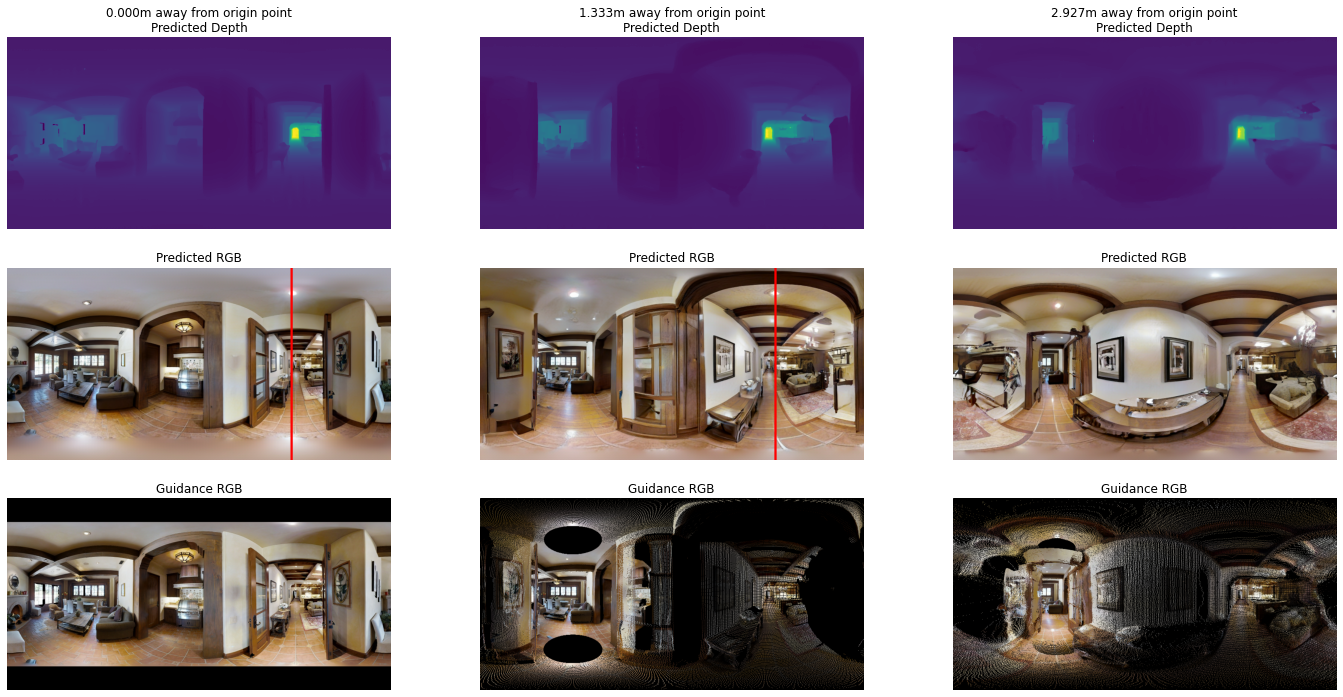

In [ ]:
def mark_heading_on_img(img, heading):
  """Adds a red line indicating direction of movement."""
  width = img.shape[1]
  # Map to [0, 2pi] domain.
  heading = heading + (2 * math.pi) * tf.cast(heading <= 0, tf.float32) % (2 * math.pi)
  if heading < 0:
    heading += 2 * math.pi
  heading_deg = heading / (2 * math.pi) * 360
  heading_proportion = heading / (2 * math.pi)
  img[:, int(heading_proportion * width)-3:int(heading_proportion * width)+3, :] = [255, 0, 0]
  return img

size_scale = 4
num_display_items = 3
path_len = len(predicted_data['rgb'])
fig, ax = plt.subplots(
    num_display_items,
    path_len,
    figsize=(2 * size_scale * path_len, num_display_items * size_scale))

for i in range(path_len):
  pred_depth = predicted_data['depth'][i][0, ...]
  pred_rgb = predicted_data['rgb'][i][0, ...]
  proj_rgb = predicted_data['proj_rgb'][i][0, ...]

  if i < path_len - 1:
    c1 = predicted_data['pos'][i][0, ...]
    c2 = predicted_data['pos'][i+1][0, ...]
    heading = tf.math.atan2(c1[0]-c2[0], c1[1]-c2[1])
    mark_heading_on_img(pred_rgb, heading)

  _ = ax[0, i].imshow(pred_depth)
  ax[0, i].set_title(f'{predicted_data["distance"][i]:.3f}m away from origin point\nPredicted Depth')
  _ = ax[1, i].imshow(pred_rgb)
  ax[1, i].set_title('Predicted RGB')
  _ = ax[2, i].imshow(proj_rgb)
  ax[2, i].set_title('Guidance RGB')
  for j in range(num_display_items):
    ax[j, i].axis('off')
plt.show()

## Continuous Video Generation

In addition to image generation, SE3DS can also be used for generating continuous video sequences ([video example](https://www.youtube.com/watch?v=lhwwlrRfFp0)).

This can be done by interpolating between coordinates.

In [ ]:
# Distance between frames in metres. Predictions are sampled every distance_per_frame meters.
distance_per_frame = 0.1
update_every_dist = int(0.1 / distance_per_frame)  # Add points every x iteration.
num_frames = positions.shape[1]

# Reset and add initial observation as a context frame.
stoch_model.reset_memory()

start_pos = positions[:, 0, :]
# input_seg is not used by the model, so we just pass a tensor of zeros.
input_seg = tf.zeros((1, image_size, image_size * 2, 1), tf.int32)  # (1, H, W, 1)
input_depth = input_depth_frames  # (1, H, W)
input_rgb = input_rgb_frames

stoch_model.add_to_memory(input_rgb, input_seg, input_depth, start_pos)

# Run inference.
predicted_data = collections.defaultdict(list)
total_dist = 0
for frame_idx in tqdm(range(1, num_frames), position=0):
  start_pos = positions[:, frame_idx-1, :]
  end_pos = positions[:, frame_idx, :]
  dist = tf.norm(end_pos - start_pos)
  num_sub_frames = int(dist / distance_per_frame)
  position_interpolations = np.linspace(start_pos, end_pos, num_sub_frames, endpoint=False)
  position_interpolations = np.transpose(position_interpolations, (1, 0, 2))  # (N, num_sub_frames, 3)
  for i in range(num_sub_frames):
    outputs = stoch_model(position_interpolations[:, i, :],
                          add_preds_to_memory=(i == 0),
                          sample_noise=False)
    total_dist += dist / num_sub_frames
    predicted_data['distance'].append(total_dist.numpy())
    predicted_data['proj_rgb'].append(outputs.proj_rgb.numpy())
    predicted_data['proj_depth'].append(outputs.proj_depth.numpy())
    predicted_data['pred_rgb'].append(outputs.pred_rgb.numpy())
    predicted_data['pred_depth'].append(outputs.pred_depth.numpy())

100%|██████████| 2/2 [02:22<00:00, 71.28s/it]


Display video sequences.

In [ ]:
# Subtitles
distance_text = ['Groundtruth frame'] + [f'Distance traveled: {d:.2f}m' for d in predicted_data['distance']]

# RGB outputs
output_rgb_frames = np.concatenate(
    [tf.cast(input_rgb_frames, tf.uint8)] + predicted_data['pred_rgb'],
    axis=0)
# Depth outputs
output_depth_frames = np.concatenate(
    [tf.cast(input_depth_frames, tf.float32)] + predicted_data['pred_depth'],
    axis=0)

show_animation([output_rgb_frames, output_depth_frames], distance_text, figsize_scale=5)